# Датасет diabetes (эталонный)

In [1]:
import numpy as np

import bamt.preprocessors
import bamt.networks as Nets
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer
from itertools import product
from pgmpy.estimators import  K2Score

from auxiliary import *

imagespath = 'C:/Users/Acer/PycharmProjects/BAMTclone/BAMT/experiments2/images'

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function indicating the function which scores likelihood of diabetes based on family history
- Age: Age (years)
- Outcome: Class variable (0 or 1)

- Уровни признаков после разбиения выносятся в отдельные столбцы в результате one-hot encoding и номер в конце имени признака обозначает уровень этого признака: 0 --- наименьшие значения, 2 --- наибольшие
- Ручное разбиение не рассматривалось, рассмотрены лишь разбиения признаков по уровням по квантилям и равномерное разбиение. У обоих подходов есть свои проблемы: по квантилям можно получить либо меньше уровней разбиения (в том числе и лишь один уровень, так как квантили могут совпасть), а равномерное разбиение может приводить к тому, что данному уровню признака может отвечать малый объём выборки в сравнении с остальными уровнями
- Также рассматривалась зависимость от выбора скора, по которому строится БС. mutual info даёт более простую сеть, чем BIC в рамках подхода с использованием one-hot encoding уровней признаков
- Поскольку нам неинтересно взаимодействие различных уровней одного и того же признака, нужно исключать соответствующие дуги в БС из white-list

In [2]:
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Разбиение признаков по квантилям

In [3]:
np.random.seed(SEED)
random.seed(SEED)

qresult = construct_by_quantiles(data, ['Outcome'])
bn = qresult['bn']

c=bn.plot2(imagespath , "bn11.html", custom_mapper={'Outcome': {0: 'NoDia', 1: 'HasDia'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


![](images/bn11.png)

In [12]:
c=bn.plot_for_specific_nodes(['Outcome0', 'Outcome1'], imagespath , "subbn11.html", custom_mapper={'Outcome': {0: 'NoDia', 1: 'HasDia'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### Проблема разбиения по квантилям: можно получить пустое состояния (если есть значение признака, имеющее большую вероятность в сравнении с остальными значениями)

## Равномерное разбиение признаков

In [4]:
np.random.seed(SEED)
random.seed(SEED)

uqresult = construct_by_uniform(data, ['Outcome'])
ubn = uqresult['bn']

c=ubn.plot2(imagespath , "ubn11.html", custom_mapper={'Outcome': {0: 'NoDia', 1: 'HasDia'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


![](images/ubn11.png)

In [13]:
c=ubn.plot_for_specific_nodes(['Outcome0', 'Outcome1'], imagespath , "sububn11.html", custom_mapper={'Outcome': {0: 'NoDia', 1: 'HasDia'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Какие связи действительны
- высокий уровень инсулина --- высокое давление (*Insulin can increase blood pressure via several mechanisms: increased renal sodium reabsorption, activation of the sympathetic nervous system, alteration of transmembrane ion transport, and hypertrophy of resistance vessels*, https://doi.org/10.2165/00003495-199300462-00024)
- меньший возраст --- меньшее кол-во беременностей и то же соотношение между высокими показателями
- Высокое значение diabetes pedigree function (высокая родовая предрасположенность к диабету) --- наличие диабета
-

## KMeansDiscretizer с тремя bin'ами

In [5]:
np.random.seed(SEED)
random.seed(SEED)

kqresult = construct_by_kmeans(data, ['Outcome'])
kbn = kqresult['bn']

c=kbn.plot2(imagespath , "kbn11.html", custom_mapper={'Outcome': {0: 'NoDia', 1: 'HasDia'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [14]:
c=kbn.plot_for_specific_nodes(['Outcome0', 'Outcome1'], imagespath , "subkbn11.html", custom_mapper={'Outcome': {0: 'NoDia', 1: 'HasDia'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [6]:
kencoder, data_kdiscretized_enc = kqresult['encoder'], kqresult['disc_data']

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

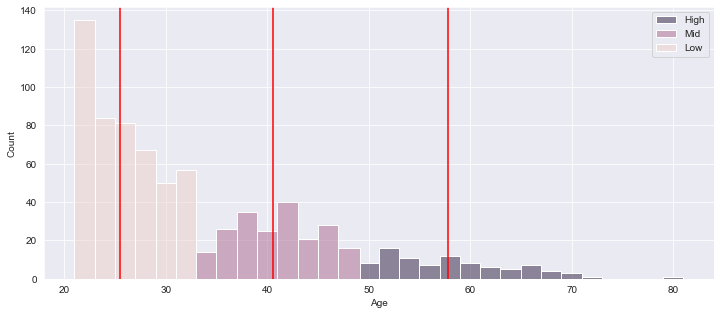

In [7]:
print_histogram('Age', data, data_kdiscretized_enc, kencoder)

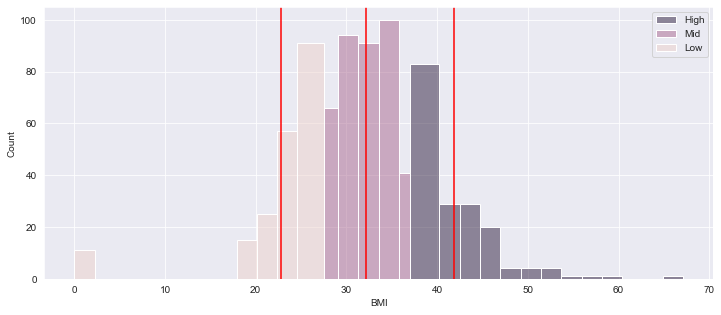

In [8]:
print_histogram('BMI', data, data_kdiscretized_enc, kencoder)

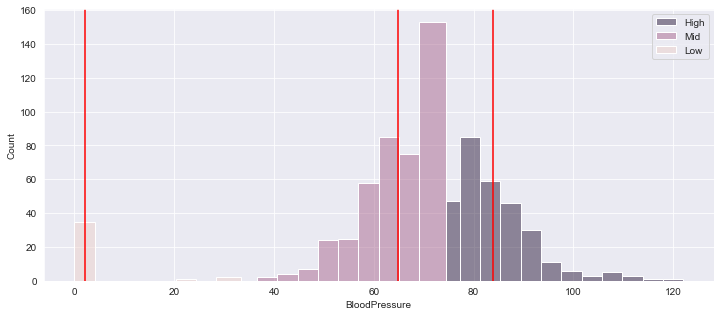

In [9]:
print_histogram('BloodPressure', data, data_kdiscretized_enc, kencoder)

![](images/kbn11.png)

In [10]:
all_edges = list(set(["-".join(e) for e in bn.edges + ubn.edges + kbn.edges])) #white list for the next bn

In [11]:
tradeoffbn = Nets.DiscreteBN()
nodes = list(dict.fromkeys(sum([x.split("-") for x in all_edges], start=[])))
tradeoffbn.add_nodes(dict(types={cat: 'disc' for _, cat in enumerate(nodes)}))

params = {'white_list': [(x[0], x[1]) for x in [y.split("-") for y in all_edges]]}

tradeoffbn.add_edges(data_kdiscretized_enc.astype("int32"), scoring_function=("K2",K2Score), params=params)

c=tradeoffbn.plot2(imagespath, "tbn11.html", custom_mapper={'Outcome': {0: 'NoDia', 1: 'HasDia'}})

  0%|          | 0/1000000 [00:00<?, ?it/s]

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


![](images/tbn11.png)

In [15]:
c=tradeoffbn.plot_for_specific_nodes(['Outcome0', 'Outcome1'], imagespath , "subtbn11.html", custom_mapper={'Outcome': {0: 'NoDia', 1: 'HasDia'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
